In [1]:
basedir = "../.."
data_file = "experiments/pilot_random1_player_round_slim.csv"
device = "cpu"
# experiment_names = ["trail_rounds_2"]
experiment_names = ["random_1"]

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from itertools import permutations
import torch
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import wandb


In [3]:
def create_decayed_round_feature(df, decay_start, decay_end):
    decay_range = decay_end - decay_start
    df.loc[df['round_number'] < decay_start, 'decay_feature'] = 1
    df.loc[df['round_number'] >= decay_end, 'decay_feature'] = 0
    df.loc[(df['round_number'] >= decay_start) & (df['round_number'] < decay_end), 'decay_feature'] = 1 - ((df['round_number'] - decay_start) / decay_range)
    return df


df = pd.read_csv(os.path.join(basedir, data_file))

df = df[df['experiment_name'].isin(experiment_names)]

# Get all unique player ids
unique_player_ids = df['player_id'].unique()

# Generate all permutations of player ids
player_permutations = list(permutations(unique_player_ids))

# Create an empty dataframe to store augmented data
augmented_df = pd.DataFrame()

# Iterate over all permutations
for i, perm in enumerate(player_permutations):
    
    # Create a copy of the original dataframe
    df_copy = df.copy()
    
    # Create a new column for permuted player ids
    df_copy['new_player_id'] = df_copy['player_id'].apply(lambda x: perm[unique_player_ids.tolist().index(x)])
    
    # Add a column indicating permutation group
    df_copy['perm_group'] = i

    # Concatenate the permuted dataframe to the augmented dataframe
    augmented_df = pd.concat([augmented_df, df_copy])

# Reset the index
augmented_df = augmented_df.reset_index(drop=True)

# Use the augmented dataframe from now on
df = augmented_df

# Create dummy variables for 'new_player_id'
df = pd.concat([df, pd.get_dummies(df['new_player_id'], prefix='player_id')], axis=1)

# Add cyclic encoding for round_number
df['round_number_sin'] = np.sin(2*np.pi*df['round_number']/6)
df['round_number_cos'] = np.cos(2*np.pi*df['round_number']/6)

# Add linearly decaying feature for the first three rounds
df = create_decayed_round_feature(df, 0, 3) 

# Standardize 'contribution' and 'punishment'
scaler = StandardScaler()
df[['contribution_scaled', 'punishment_scaled']] = scaler.fit_transform(df[['contribution', 'punishment']])

# Now, let's create the events
df_contribution = df.copy()
df_contribution['event_type'] = 'contribution'
df_contribution['event_id'] = 0
df_contribution.rename(columns={'contribution': 'event_value_raw', 'contribution_scaled': 'event_value'}, inplace=True)

df_punishment = df.copy()
df_punishment['event_type'] = 'punishment'
df_punishment['event_id'] = 1
df_punishment.rename(columns={'punishment': 'event_value_raw', 'punishment_scaled': 'event_value'}, inplace=True)

# Concatenate the two dataframes
df = pd.concat([df_contribution, df_punishment])

# Make sure the data is still sorted correctly after the concatenation
df = df.sort_values(['perm_group', 'episode_id', 'new_player_id', 'round_number', 'event_id'])



In [4]:
pad_idx = -1



input_columns = ['player_id_0', 'player_id_1', 'player_id_2', 'player_id_3',
                 'round_number_sin', 'round_number_cos', 'decay_feature', 'event_value', 'event_id']
target_column = 'event_value_raw'

num_classes = 31
def create_sequences(df, input_columns, target_column, pad_idx=-1):
    sequences = []
    targets = []

    for perm_group in df['perm_group'].unique():
        perm_group_data = df[df['perm_group'] == perm_group]

        for episode_id in perm_group_data['episode_id'].unique():
            episode_data = perm_group_data[perm_group_data['episode_id'] == episode_id]

            sequence = torch.tensor(episode_data[input_columns].astype('float64').values, dtype=torch.float32)
            target = torch.tensor(episode_data[target_column].values, dtype=torch.int64)

            sequences.append(sequence)
            targets.append(target)

    # Pad the sequences so they all have the same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=pad_idx)

    return padded_sequences, padded_targets


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')  # <-- saves model
        self.val_loss_min = val_loss



# Define the Transformer model
class GPTLikeTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, num_classes, dropout):
        super(GPTLikeTransformer, self).__init__()

        # Define model dimensions
        self.d_model = d_model  # Number of features in input

        # Define the embedding layer that maps the input to the desired number of features
        self.embedding = nn.Linear(9, d_model)  # Input: (batch_size, seq_len, 8), Output: (batch_size, seq_len, d_model)

        # Define the Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout=dropout), num_layers
        )  # Input: (seq_len, batch_size, d_model), Output: (seq_len, batch_size, d_model)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout)

        # Define the decoder layer that maps the output of the Transformer to the desired number of classes
        self.decoder = nn.Linear(d_model, num_classes)  # Input: (batch_size, seq_len, d_model), Output: (batch_size, seq_len, num_classes)

    # Function to generate a mask for the decoder to prevent it from "seeing" future tokens
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask  # Output: (seq_len, seq_len)

    def forward(self, x):
        # Embed the input
        x = self.embedding(x) * np.sqrt(self.d_model)  # Input: (batch_size, seq_len, 8), Output: (batch_size, seq_len, d_model)

        # Transformer expects seq_len, batch, embedding_dim so we permute the dimensions
        x = x.permute(1, 0, 2)  # Output: (seq_len, batch_size, d_model)

        # Create a mask for the Transformer
        tgt_mask = self._generate_square_subsequent_mask(x.size(0)).to(x.device)  # Output: (seq_len, seq_len)

        # Apply the Transformer
        x = self.transformer_decoder(tgt=x, memory=x, tgt_mask=tgt_mask)  # Output: (seq_len, batch_size, d_model)

        # Apply dropout
        x = self.dropout(x)

        # Permute back to batch, seq_len, embedding_dim for linear layer
        x = x.permute(1, 0, 2)  # Output: (batch_size, seq_len, d_model)

        # Apply the decoder
        x = self.decoder(x)  # Output: (batch_size, seq_len, num_classes)

        return x  # No need to squeeze the last dimension, Output: (batch_size, seq_len, num_classes)
    


# Define the Dataset
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data[:-1]  # Shift the data by one to avoid leaking future information
        self.targets = targets[1:]  # The target for each sequence is the next sequence
        self.mask = torch.zeros_like(self.targets)  # Create a mask to only calculate loss on non-padded tokens
        self.mask[:,::2] = 1
        self.mask[self.targets == -1] = 0  # Set the mask to 0 for padded tokens

    def __getitem__(self, index):
        x = self.data[index]  # Shape: (seq_len, 8)
        y = self.targets[index]  # Shape: (seq_len, 1)
        mask = self.mask[index]  # Shape: (seq_len, 1)
        return x, y, mask

    def __len__(self):
        return len(self.data)

In [5]:

wandb.init(project='ai-gov-transformer', entity='chm-hci')


# Create a wandb config
wandb.config.update({
    'd_model': 64,
    'nhead': 8,
    'num_layers': 4,
    'dim_feedforward': 256,
    'dropout': 0.3,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'patience': 15,
    'n_epochs': 200,
    'batch_size': 16
})



# # Initialize the model
# d_model = 32
# nhead = 2
# num_layers = 2
# dim_feedforward = 128
# dropout = 0.5  # you can adjust this value based on your needs, common values are around 0.1 to 0.5


# # Define hyperparameters
# n_epochs = 200
# batch_size = 16
# learning_rate = 0.001
# weight_decay=1e-5
# patience=10



config = wandb.config  # Now you can access your hyperparameters through config

# Define hyperparameters
n_epochs = config.n_epochs

# Get unique permutation groups
unique_perm_groups = df['perm_group'].unique()

# Split the perm_groups into train and validation groups
train_perm_groups, val_perm_groups = train_test_split(unique_perm_groups, test_size=0.2)

# Create training and validation dataframes based on the split perm_groups
train_df = df[df['perm_group'].isin(train_perm_groups)]
val_df = df[df['perm_group'].isin(val_perm_groups)]

# Now create sequences for both train and validation dataframes
sequences_train, targets_train = create_sequences(train_df, input_columns, target_column, pad_idx=pad_idx)
sequences_val, targets_val = create_sequences(val_df, input_columns, target_column, pad_idx=pad_idx)

# Create your Dataset
train_dataset = MyDataset(sequences_train, targets_train)
val_dataset = MyDataset(sequences_val, targets_val)

# Create your DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# Initialize the model
model = GPTLikeTransformer(config.d_model, config.nhead, config.num_layers, config.dim_feedforward, num_classes, config.dropout).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)  # pad_idx is the index used for padding in your dataset
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=config.patience, verbose=True)

for epoch in range(1, n_epochs + 1):
    # Training
    model.train()
    train_losses = []
    for sequences_batch, targets_batch, mask_batch in train_dataloader:
        sequences_batch, targets_batch, mask_batch = sequences_batch.to(device), targets_batch.to(device), mask_batch.to(device)
        optimizer.zero_grad()

        output = model(sequences_batch)  # Shape: (batch_size, seq_len, num_classes)

        output = output.view(-1, output.size(-1))  # Shape: (batch_size*seq_len, num_classes)
        targets_batch = targets_batch.contiguous().view(-1)  # Shape: (batch_size*seq_len,)
        mask_batch = mask_batch.contiguous().view(-1)  # Shape: (batch_size*seq_len,)

        loss = criterion(output, targets_batch)  # Compute the loss

        # Apply mask to the loss
        loss = loss * mask_batch.float()

        # Normalize the loss
        loss = loss.sum() / mask_batch.float().sum()  




        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for sequences_batch, targets_batch, mask_batch in train_dataloader:
            sequences_batch, targets_batch, mask_batch = sequences_batch.to(device), targets_batch.to(device), mask_batch.to(device)
            output = model(sequences_batch)  # Shape: (batch_size, seq_len, num_classes)

            output = output.view(-1, output.size(-1))  # Shape: (batch_size*seq_len, num_classes)
            targets_batch = targets_batch.contiguous().view(-1)  # Shape: (batch_size*seq_len,)
            mask_batch = mask_batch.contiguous().view(-1)  # Shape: (batch_size*seq_len,)

            val_loss = criterion(output, targets_batch)  # Compute the loss

            # Apply mask to the loss
            val_loss = val_loss * mask_batch.float()

            # Normalize the loss
            val_loss = val_loss.sum() / mask_batch.float().sum()  
            val_losses.append(val_loss.item())
    # Print losses
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

    wandb.log({
        'Train Loss': np.mean(train_losses),
        'Val Loss': np.mean(val_losses),
        'Epoch': epoch
    })


    early_stopping(np.mean(val_losses), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


# load the last checkpoint with the best model
torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

wandb.finish()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: levinb (chm-hci). Use `wandb login --relogin` to force relogin


Epoch 2/200, Train Loss: 2.5557, Val Loss: 2.3179
Validation loss decreased (inf --> 2.317854).  Saving model ...
Epoch 3/200, Train Loss: 2.3597, Val Loss: 2.2889
Validation loss decreased (2.317854 --> 2.288879).  Saving model ...
Epoch 4/200, Train Loss: 2.3197, Val Loss: 2.2595
Validation loss decreased (2.288879 --> 2.259459).  Saving model ...
Epoch 5/200, Train Loss: 2.2788, Val Loss: 2.1883
Validation loss decreased (2.259459 --> 2.188287).  Saving model ...
Epoch 6/200, Train Loss: 2.2327, Val Loss: 2.1853
Validation loss decreased (2.188287 --> 2.185323).  Saving model ...
Epoch 7/200, Train Loss: 2.1784, Val Loss: 2.0927
Validation loss decreased (2.185323 --> 2.092749).  Saving model ...
Epoch 8/200, Train Loss: 2.1524, Val Loss: 2.0433
Validation loss decreased (2.092749 --> 2.043276).  Saving model ...
Epoch 9/200, Train Loss: 2.1068, Val Loss: 2.0106
Validation loss decreased (2.043276 --> 2.010632).  Saving model ...
Epoch 10/200, Train Loss: 2.0712, Val Loss: 1.9864
Va

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,200
Train Loss,0.76489
Val Loss,0.19202


In [7]:
# Switch the model to evaluation mode
model.eval()

# Prepare to collect predictions and true labels
all_predictions = []
all_true_labels = []

# Don't update model parameters and don't compute gradients
with torch.no_grad():
    for sequences_batch, targets_batch, mask in val_dataloader:
        sequences_batch = sequences_batch.to(device)
        targets_batch = targets_batch.to(device)

        # Run the model
        output = model(sequences_batch)

        # Get the model predictions
        _, predicted = torch.max(output, 2)

        # Collect all predictions and true labels
        all_predictions.append(predicted.cpu().numpy())
        all_true_labels.append(targets_batch.cpu().numpy())

# Concatenate all predictions and true labels
all_predictions = np.concatenate(all_predictions)
all_true_labels = np.concatenate(all_true_labels)


In [ ]:
all_predictions.shape

(244, 128)

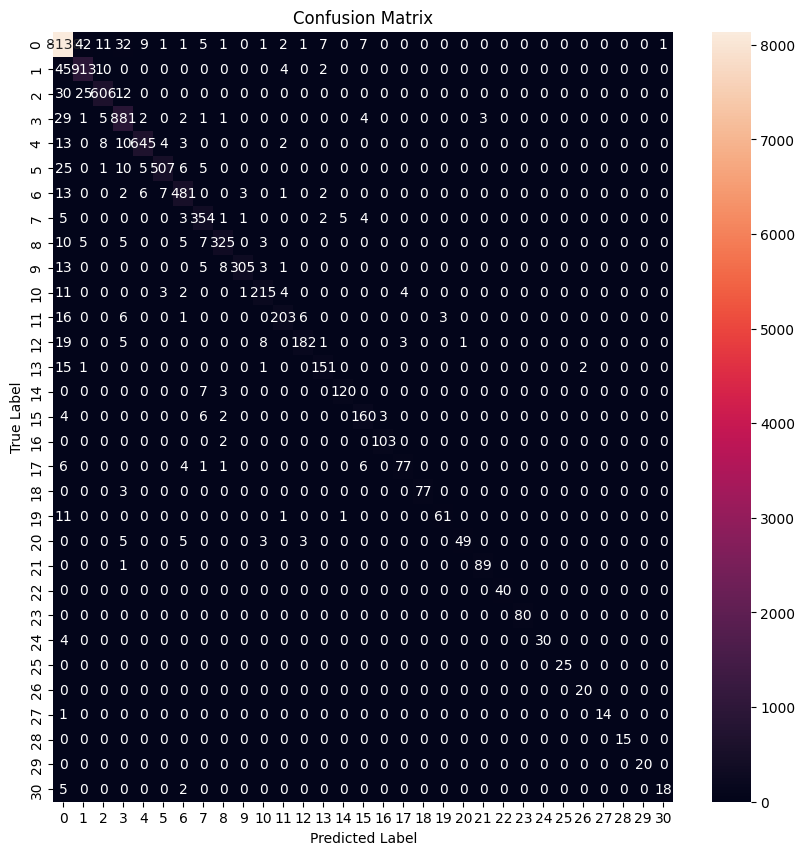

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

allt_ = all_true_labels[:,1::2].flatten()
allp_ = all_predictions[:,1::2].flatten()

# remove the padding tokens
allt = allt_[allt_ != -1]
allp = allp_[allt_ != -1]


# Compute the confusion matrix
cm = confusion_matrix(allt, allp)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


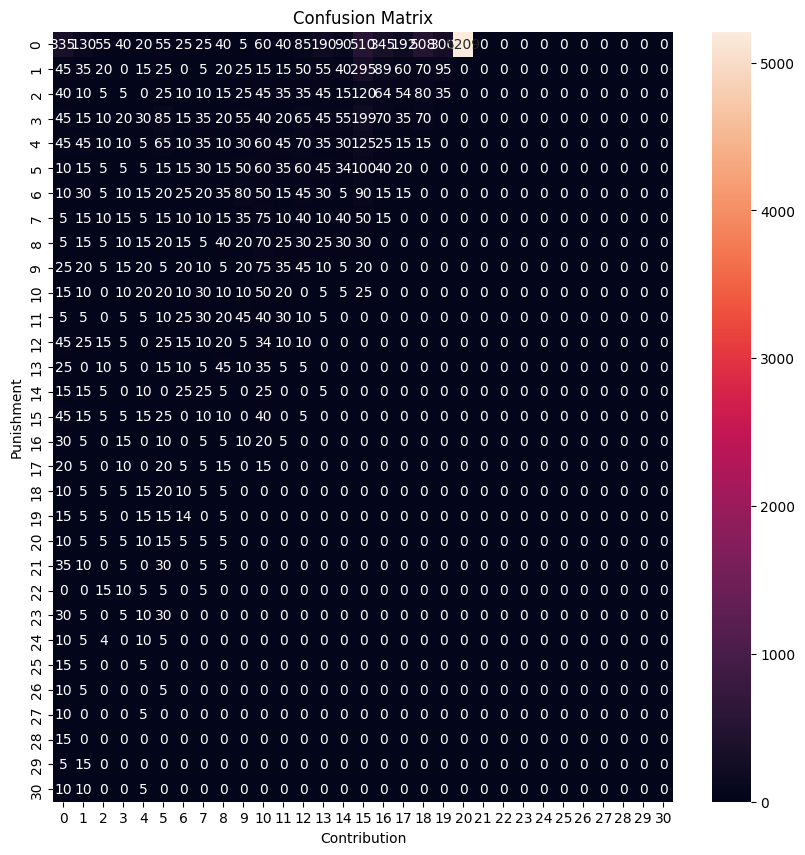

In [ ]:
allt_ = all_true_labels[:,::2].flatten()
# allp_ = all_predictions[:,::2].flatten()

# remove the padding tokens
allt = allt_[allt_ != -1]
# allp = allp_[allt_ != -1]


callt_ = all_true_labels[:,1::2].flatten()
# callp_ = all_predictions[:,1::2].flatten()

# remove the padding tokens
callt = callt_[callt_ != -1]
# callp = callp_[callt_ != -1]


# Compute the confusion matrix
cm = confusion_matrix(callt, allt)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Punishment")
plt.xlabel("Contribution")
plt.show()

In [ ]:
callt.shape

(15616,)

In [ ]:
allt.shape

(15616,)

In [ ]:
allp.shape

(15616,)